# Machine Learning Pipeline - Production

Check the python kernel we are using, should be the local one, not the one in the virtual environment. <br>
NOTE: A proper virtual environment will be setup later on

In [1]:
import sys
print(sys.executable)

/bin/python3


## Define Variables

Set up main variables that will be called later on, for readibility purposes

In [2]:
install_bool = True
path_to_datasets = "/home/ieo7429/Desktop/THESIS_GAB/outfiles/target_variables/ML_tables_regression_classification_BRCA_v2.RData"
mode = "regrout"

cols_to_drop = ["ampl_score","del_score","mean_log2FC","weighted_log2FC", "joint_probability", "bool_diff_acc", 
                "sign_mean_log2FC_2", "sign_mean_log2FC_3", 
                "weighted_coef_of_var_log2FC", "weighted_log2FC", "bin", "Type"]

if "ampl_score" in cols_to_drop and "del_score" in cols_to_drop:
    condition = "without_CNA"
else:
    condition = "with CNA"

n_jobs = 60
nthread = 60
n_iter_bsearch = 50
n_iter_rsearch = 100

split_random_state = 489574
classifier_seed = 3737
classifier_random_state = 39473209
hypertune_random_state_bsearch = 3847
hypertune_random_state_rsearch = 49574
kfold_random_state = 4909

outer_cv = 5
inner_cv = 3
plot_variation = False
plot_gain = False
plot_shap = True

X_train_filename = "Classification_Output/classification_X_train_red"; X_test_filename = "Classification_Output/classification_X_test_red"
y_train_filename = "Classification_Output/classification_y_train_red"; y_test_filename = "Classification_Output/classification_y_test_red"
bin_train_filename = "Classification_Output/classification_bin_train_red"; bin_test_filename = "Classification_Output/classification_bin_test_red"
model_filename = "Classification_Output/classification_final_model"

## Install packages

Install all needed packages

In [3]:
from IPython.display import clear_output

if install_bool:
    ! pip install pickleshare
    ! pip install pandas
    ! pip install scikit-learn
    ! pip install seaborn
    ! pip install scipy
    ! pip install --upgrade pip setuptools wheel
    ! pip install rpy2
    ! pip install shap
    ! pip install "numpy<=2.1"
    %pip install -U ipywidgets

clear_output(wait = False)

## Import libraries

Import all packages

In [4]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import rpy2.robjects as ro
import xgboost as xgb
import shap
import warnings
import pickle
import pickleshare
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from skopt import BayesSearchCV
from sklearn.feature_selection import SelectFromModel

## Define Functions

### load_datasets_from_r
Reads "ML.Tables" .Rdata file and converts it to a nested dictionary.

In [5]:
def load_datasets_from_r(file_path):

    """ 
    The function uses rpy2 to load datasets from an RData file.
    In particular it expects a list of data.frames
    It returns a dictionary of pandas DataFrames.
    """
    
    pandas2ri.activate()

    ro.r['load'](file_path) # load the .RData

    env = ro.globalenv # set the environment

    r_list = env[list(env.keys())[0]] # take the list object

    list_names = ro.r['names'](r_list) # take the names
    list_names = [str(name) for name in list_names]

    df_dict = {} # initialize outer dictionary
    with (ro.default_converter + ro.pandas2ri.converter).context(): # start the conversion
    # the conversion transforms a list of lists of lists of data.frames 
    # to a list of dictionaries of dictionaries of dictionaries of DataFrame
        i = 0
        for outer_dict in r_list:
            df_dict[list_names[i]] = outer_dict
            i += 1
            
    return(df_dict)

### gini_coefficient

Function to compute the gini coefficient (2 * AUC - 1)

In [6]:
def gini_coefficient_score(y_true, y_pred_prob, **kwargs):
    y_score = y_pred_prob
    auc_score = sk.metrics.roc_auc_score(y_true, y_score)
    gini_coef = 2 * auc_score - 1
    return gini_coef

In [7]:
gini_coefficient = sk.metrics.make_scorer(gini_coefficient_score, response_method = "predict_proba", greater_is_better= True)

### feature_selector
his function performs Incremental Feature Selection (IFS) to produce a reduced model <br> with best gini coefficient (2 * AUC - 1) performance with cross validation.
Mean absolute SHAP values are used to select features

In [8]:
def feature_selector_shap(feature_names, feature_importances, model, 
                          X_train, X_test, y_train, inner_cv,
                          plot = True, verbose = True):

    """
    The function takes as input feature names, feature importances, 
    a XGBoost Classifier object, the training and test dataset
    and returns the reduced training and test datasets.
    - plot parameter regulates whether or not to plot the Gini Coefficient vs number of feature plot
    - verbose parameter regulates whether or not to produce a text output
    """

    thresholds = np.sort(feature_importances) # sort the feature importances
    num_features_list = [] # initialize list
    gini_coef_list = [] # initialize list
    
    for threshold in thresholds: # iterate over thresholds
        
        vars_to_keep = np.where(feature_importances >= threshold)[0]
        X_train_selected = X_train.iloc[:,vars_to_keep]

        gini_coef_scores = sk.model_selection.cross_val_score(estimator = model, 
                                                              X = X_train_selected, y = y_train, 
                                                              scoring = gini_coefficient, cv = inner_cv)
        mean_gini_coef_score = np.mean(gini_coef_scores)
        
        num_features_list.append(X_train_selected.shape[1]) # append
        gini_coef_list.append(mean_gini_coef_score) # append

        if verbose:
            print(f'> threshold={threshold}, features={X_train_selected.shape[1]}, gini coefficient={mean_gini_coef_score}')
        
        if len(vars_to_keep) == 1:
            break

    if plot:
        plt.figure(figsize=(8, 6))
        plt.plot(num_features_list, gini_coef_list, marker='o')
        plt.xlabel('Number of Selected Features')
        plt.ylabel('cross validated mean Ginny coefficient')
        plt.title('Gini coefficient vs. Number of Selected Features')
        plt.grid(True)
        plt.show()

    optimal_threshold_index = np.argmax(gini_coef_list)
    optimal_num_features = num_features_list[optimal_threshold_index]
    
    if (optimal_threshold_index) == 0:
        optimal_threshold = 0
    else:   
        optimal_threshold = thresholds[optimal_threshold_index - 1]

    if verbose:
        print(f"Optimal Threshold: {optimal_threshold:.4f}")
        print(f"Number of Selected Features: {optimal_num_features}")
        print(f"Gini coef at Optimal Threshold: {gini_coef_list[optimal_threshold_index]:.4f}")
        print("\n")
        
    n = 5
    selected_features = feature_names[np.where(feature_importances > optimal_threshold)]
    selected_features = [str(name) for name in selected_features]
    discarded_features = [str(name) for name in feature_names if str(name) not in selected_features]

    if verbose:
        print("Selected features are: \n")
        for i in range(0,len(selected_features), n):
            print("  ".join(selected_features[i:i+n]))
        print("\n")
        print("Discarded features are: \n")
        for i in range(0,len(discarded_features), n):
            print("  ".join(discarded_features[i:i+n]))

    X_train_reduced = X_train[selected_features]
    X_test_reduced = X_test[selected_features]
    
    return(X_train_reduced, X_test_reduced, selected_features)    

### Nested CV

This function performs nested cross validation, optimizing the model at each step in order to properly estimate the model's error

In [9]:
def nested_CV(outer_cv, inner_cv,
               X_train, y_train, 
               model, search_space, 
               n_jobs, n_iter_bsearch, verbose):
    
    """
    The function performs nested cross validation to estimate model's error rate
    It take the cv number, the training dataset, the target variable, the model or a BayesSearchCV
    and a search space to perform hyperparameter tuning
    """

    kf = sk.model_selection.KFold(n_splits = outer_cv, 
                                  shuffle = True, 
                                  random_state = kfold_random_state)
    
    accuracy_array = np.zeros(outer_cv)
    f1_array = np.zeros(outer_cv)
    precision_array = np.zeros(outer_cv)
    recall_array = np.zeros(outer_cv)
    roc_auc_array = np.zeros(outer_cv)
    predictions_array = np.zeros(len(X_train))
    probas_array = np.zeros(len(X_train))
    
    i = 0
    for train_index, val_index in kf.split(X_train):

        if verbose:
            print(f"Fold #{i + 1}")
        
        if verbose:
            print("STEP 1 (Splitting)")
        
        X_train_cv, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_cv, y_val = y_train[train_index], y_train[val_index]
        
        if verbose:
            print("STEP 2 (Tuning)")

        opti = BayesSearchCV(
            estimator = model,
            search_spaces = search_space,
            n_iter = n_iter_bsearch,
            cv = inner_cv,
            random_state = hypertune_random_state_bsearch,
            refit = True,
            n_jobs = n_jobs,
            verbose = False
        )

        opti.fit(X_train_cv, y_train_cv)
        best_model = opti.best_estimator_
    
        if verbose:
            print("STEP 3 (Prediction)")

        cv_predictions = best_model.predict(X_val)
        cv_pred_probas = best_model.predict_proba(X_val)[:,1]
        
        cv_accuracy = sk.metrics.accuracy_score(y_val, cv_predictions)
        cv_f1 = sk.metrics.f1_score(y_val, cv_predictions)
        cv_precision = sk.metrics.precision_score(y_val, cv_predictions)
        cv_recall = sk.metrics.recall_score(y_val, cv_predictions)
        cv_roc_auc = sk.metrics.roc_auc_score(y_val, cv_pred_probas)
                
        accuracy_array[i] = cv_accuracy 
        f1_array[i] = cv_f1
        precision_array[i] = cv_precision
        recall_array[i] = cv_recall
        roc_auc_array[i] = cv_roc_auc
        predictions_array[val_index] = cv_predictions
        probas_array[val_index] = cv_pred_probas
        
        i += 1

    return(accuracy_array, f1_array, precision_array, recall_array, roc_auc_array, predictions_array, probas_array)

### Nested CV la vendetta

In [10]:
def nested_CV_revenge(outer_cv, inner_cv,
                      X_train, y_train, 
                      model, search_space, 
                      n_jobs, n_iter_bsearch, verbose):
    
    """
    The function performs nested cross validation to estimate model's error rate
    It take the cv number, the training dataset, the target variable, the model or a BayesSearchCV
    and a search space to perform hyperparameter tuning
    """
    
    kf = sk.model_selection.KFold(n_splits = outer_cv, 
                                  shuffle=True, 
                                  random_state = kfold_random_state)
    

    hyperparam_list = []
    selected_features_list = []
    accuracy_array = np.zeros(outer_cv)
    f1_array = np.zeros(outer_cv)
    precision_array = np.zeros(outer_cv)
    recall_array = np.zeros(outer_cv)
    roc_auc_array = np.zeros(outer_cv)
    predictions_array = np.zeros(len(X_train))
    probas_array = np.zeros(len(X_train))
    
    i = 0
    for train_index, val_index in kf.split(X_train):

        if verbose:
            print(f"Fold #{i + 1}")
            
        if verbose:
            print("STEP 1 (Splitting)")
            
        X_train_cv, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_cv, y_val = y_train[train_index], y_train[val_index]
        
        if verbose:
            print("STEP 2 (Tuning)")

        if verbose:
            print("STEP 2.1 (HyperParameter Tuning Part 1)")
        
        opti = BayesSearchCV(
            estimator = model,
            search_spaces = search_space,
            n_iter = n_iter_bsearch,
            cv = inner_cv,
            random_state = hypertune_random_state_bsearch,
            refit = True,
            n_jobs = n_jobs,
            verbose = 0
        )
        
        opti.fit(X_train_cv, y_train_cv)
        best_model = opti.best_estimator_

        if verbose:
            print("STEP 2.2 (SHAP)")
        
        explainer = shap.TreeExplainer(best_model)

        feature_names = best_model.feature_names_in_
        feature_importances_shap = np.mean(np.abs(explainer.shap_values(X_train_cv)), axis = 0)
    
        if verbose:
            print("STEP 2.3 (Feature selection)")
        
        X_train_cv_reduced, X_val_cv_reduced, selected_features = feature_selector_shap(feature_names, feature_importances_shap, 
                                                                                        best_model, 
                                                                                        X_train_cv, X_val, y_train_cv,
                                                                                        inner_cv,
                                                                                        plot = False, verbose = False)

        if verbose:
            print("STEP 2.4 (HyperParameter Tuning Part 2)")
        
        opti_fs = BayesSearchCV(
            estimator = best_model, 
            search_spaces = search_space, 
            n_iter = n_iter_bsearch, 
            cv = inner_cv,
            random_state = hypertune_random_state_bsearch,
            refit = True, 
            n_jobs = n_jobs,
            verbose = 0
        )
        
        opti_fs.fit(X_train_cv_reduced, y_train_cv)
        best_model_fs = opti_fs.best_estimator_
        best_params_fs = opti_fs.best_params_

        if verbose: 
            print("STEP 3 (Threshold Tuning)")

        tuner_thr = sk.model_selection.TunedThresholdClassifierCV(best_model_fs, 
                                                                  scoring = "balanced_accuracy", 
                                                                  cv = inner_cv)
        
        model_thr = tuner_thr.fit(X_train_cv_reduced, y_train_cv)
        
        if verbose:
            print("STEP 4 (Prediction)")
        
        cv_predictions = model_thr.predict(X_val_cv_reduced)
        cv_pred_probas = model_thr.predict_proba(X_val_cv_reduced)[:,1]
        
        cv_accuracy = sk.metrics.accuracy_score(y_val, cv_predictions)
        cv_f1 = sk.metrics.f1_score(y_val, cv_predictions)
        cv_precision = sk.metrics.precision_score(y_val, cv_predictions)
        cv_recall = sk.metrics.recall_score(y_val, cv_predictions)
        cv_roc_auc = sk.metrics.roc_auc_score(y_val, cv_pred_probas)
        
        hyperparam_list.append(best_params_fs)
        selected_features_list.append(selected_features)
        accuracy_array[i] = cv_accuracy 
        f1_array[i] = cv_f1
        precision_array[i] = cv_precision
        recall_array[i] = cv_recall
        roc_auc_array[i] = cv_roc_auc
        predictions_array[val_index] = cv_predictions
        probas_array[val_index] = cv_pred_probas
        
        i += 1

    return(hyperparam_list, selected_features_list, 
           accuracy_array, f1_array, precision_array, 
           recall_array, roc_auc_array, predictions_array, probas_array)

## Load Data

In [11]:
output_dict = load_datasets_from_r(path_to_datasets)

In [12]:
working_df = output_dict[mode]

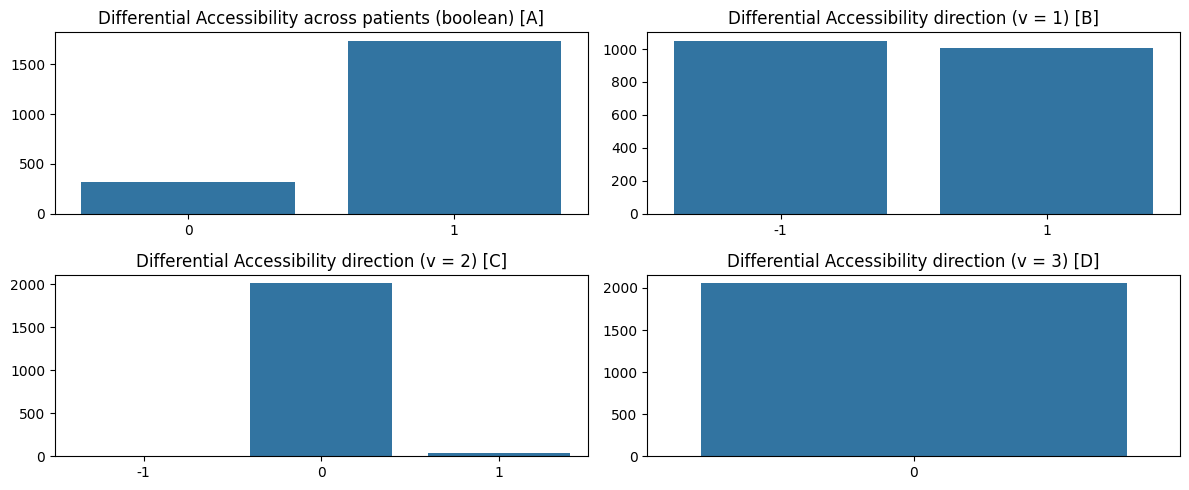

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(12, 5))

A = axes[0,0]
B = axes[0,1]
C = axes[1,0]
D = axes[1,1]

sns.barplot(working_df.bool_diff_acc.value_counts(), ax = A)
sns.barplot(working_df.sign_mean_log2FC_1.value_counts(), ax = B)
sns.barplot(working_df.sign_mean_log2FC_2.value_counts(), ax = C)
sns.barplot(working_df.sign_mean_log2FC_3.value_counts(), ax = D)

A.set_title("Differential Accessibility across patients (boolean) [A]")
B.set_title("Differential Accessibility direction (v = 1) [B]")
C.set_title("Differential Accessibility direction (v = 2) [C]")
D.set_title("Differential Accessibility direction (v = 3) [D]")

A.set_xlabel(""); A.set_ylabel("")
B.set_xlabel(""); B.set_ylabel("")
C.set_xlabel(""); C.set_ylabel("")
D.set_xlabel(""); D.set_ylabel("")

plt.tight_layout()

## Prepare Data

In [14]:
bin_ids = working_df[["bin"]]

In [15]:
working_df = working_df.drop(cols_to_drop, axis= 1)

In [16]:
X = working_df.iloc[:, 1:]
y = working_df.iloc[:, 0]

In [17]:
if "sign_mean_log2FC_1" in X.columns:
    raise Exception("Target Variable in the training set!")

In [18]:
X_train, X_test, y_train, y_test, bin_train, bin_test = sk.model_selection.train_test_split(X, y, bin_ids, test_size=0.3, random_state=split_random_state)
y_train = np.where(y_train == 1, 1, 0); y_test = np.where(y_test == 1, 1, 0)

## Prepare the Classifier and the Search Space

In [19]:
classifier = xgb.XGBClassifier(n_jobs = n_jobs, nthread = nthread, seed = classifier_seed, random_state = classifier_random_state)

search_space_bayes = {  
    'learning_rate': (0.001, 1.0, 'log-uniform'),  
    'n_estimators': (50, 500),  
    'max_depth': (3, 15),  
    'min_child_weight': (1, 10),  
    'gamma': (1e-9, 5.0, 'log-uniform'),  
    'subsample': (0.5, 1.0, 'uniform'),  
    'colsample_bytree': (0.5, 1.0, 'uniform'),  
    'colsample_bylevel': (0.5, 1.0, 'uniform'),  
    'reg_alpha': (1e-9, 10.0, 'log-uniform'),  
    'reg_lambda': (1e-9, 10.0, 'log-uniform'),  
    'scale_pos_weight': (1e-6, 100, 'log-uniform'),  
    'max_delta_step': (0, 10),  
    'objective': ['binary:logistic'],  
    'booster': ['gbtree', 'dart'],  
    'eval_metric': ['logloss', 'error', 'auc']  
}  

### NESTED CV PIPELINE

In [20]:
results = nested_CV_revenge(
    outer_cv, inner_cv,
    X_train=X_train,
    y_train=y_train,
    model=classifier,
    search_space=search_space_bayes,
    n_jobs= n_jobs, n_iter_bsearch = n_iter_bsearch,
    verbose=True
)

(
    hyperparam_list,
    selected_features_list,
    accuracy_array,
    f1_array,
    precision_array,
    recall_array,
    roc_auc_array,
    predictions_array,
    probas_array
) = results

Fold #1
STEP 1 (Splitting)
STEP 2 (Tuning)
STEP 2.1 (HyperParameter Tuning Part 1)
STEP 2.2 (SHAP)
STEP 2.3 (Feature selection)
STEP 2.4 (HyperParameter Tuning Part 2)
STEP 3 (Threshold Tuning)
STEP 4 (Prediction)
Fold #2
STEP 1 (Splitting)
STEP 2 (Tuning)
STEP 2.1 (HyperParameter Tuning Part 1)
STEP 2.2 (SHAP)
STEP 2.3 (Feature selection)
STEP 2.4 (HyperParameter Tuning Part 2)
STEP 3 (Threshold Tuning)
STEP 4 (Prediction)
Fold #3
STEP 1 (Splitting)
STEP 2 (Tuning)
STEP 2.1 (HyperParameter Tuning Part 1)
STEP 2.2 (SHAP)
STEP 2.3 (Feature selection)
STEP 2.4 (HyperParameter Tuning Part 2)
STEP 3 (Threshold Tuning)
STEP 4 (Prediction)
Fold #4
STEP 1 (Splitting)
STEP 2 (Tuning)
STEP 2.1 (HyperParameter Tuning Part 1)
STEP 2.2 (SHAP)
STEP 2.3 (Feature selection)
STEP 2.4 (HyperParameter Tuning Part 2)
STEP 3 (Threshold Tuning)
STEP 4 (Prediction)
Fold #5
STEP 1 (Splitting)
STEP 2 (Tuning)
STEP 2.1 (HyperParameter Tuning Part 1)
STEP 2.2 (SHAP)
STEP 2.3 (Feature selection)
STEP 2.4 (HyperP

In [21]:
print(f"The cross-validated accuracy (cv = {outer_cv}) is: {np.mean(accuracy_array)}")
print(f"The cross-validated f1 (cv = {outer_cv}) is: {np.mean(f1_array)}")
print(f"The cross-validated precision (cv = {outer_cv}) is: {np.mean(precision_array)}")
print(f"The cross-validated R recall (cv = {outer_cv}) is: {np.mean(recall_array)}")
print(f"The cross-validated AUC (cv = {outer_cv}) is: {np.mean(roc_auc_array)}")

The cross-validated accuracy (cv = 5) is: 0.7647914246999613
The cross-validated f1 (cv = 5) is: 0.7635125381714881
The cross-validated precision (cv = 5) is: 0.751083690334901
The cross-validated R recall (cv = 5) is: 0.7787864012886202
The cross-validated AUC (cv = 5) is: 0.8469328141659187


In [22]:
selected_features_in_at_least_one_cv = set([elem for inner_list in selected_features_list for elem in inner_list])

In [23]:
search_space_grid = {}

for dictionary in hyperparam_list:
    for k,v in dictionary.items():
        if k in search_space_grid:
            search_space_grid[k].update([v])
        else:
            search_space_grid[k] = set([v])

search_space_grid = {k : list(v) for k,v in search_space_grid.items()}

## Full Dataset Hyperparameter Tuning

In [24]:
opti = sk.model_selection.RandomizedSearchCV(estimator = classifier, 
                                             param_distributions = search_space_grid, 
                                             cv = inner_cv, 
                                             n_jobs = n_jobs,
                                             n_iter = n_iter_rsearch,
                                             random_state = hypertune_random_state_rsearch, 
                                             verbose = 0, refit = True)
opti.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constrain...
                                                      1.5741539770115064e-06],
                                        'reg_lambda': [0.25214674245184693,
                                                       0.9611580757120047,
                                                       2.619093381364049, 10.0,
                                                       1.3002135320318957e-08],
                                        'scale_pos_weight': [1.642825824640402,
                                                             2.3444329013314236,
                                                             1.4257870874904865,
                                                             1.4493937665642953,
                                                             1.2899420512630508],
                                        'subsample': [0.7717456158038967,
                                                      0.9852373968349232,
                                                      0.7774917033919722,
                                                      0.8198995084011427,
                                                      0.9831149178054596]},
                   random_state=49574)

In [25]:
model = opti.best_estimator_

## Feature Importance Analysis

Let's look at both XGBoost native feature importance and at mean absolute SHAP values as metric of feature importance

In [26]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)
shap_values_numpy = explainer.shap_values(X_train)

regrout / without_CNA


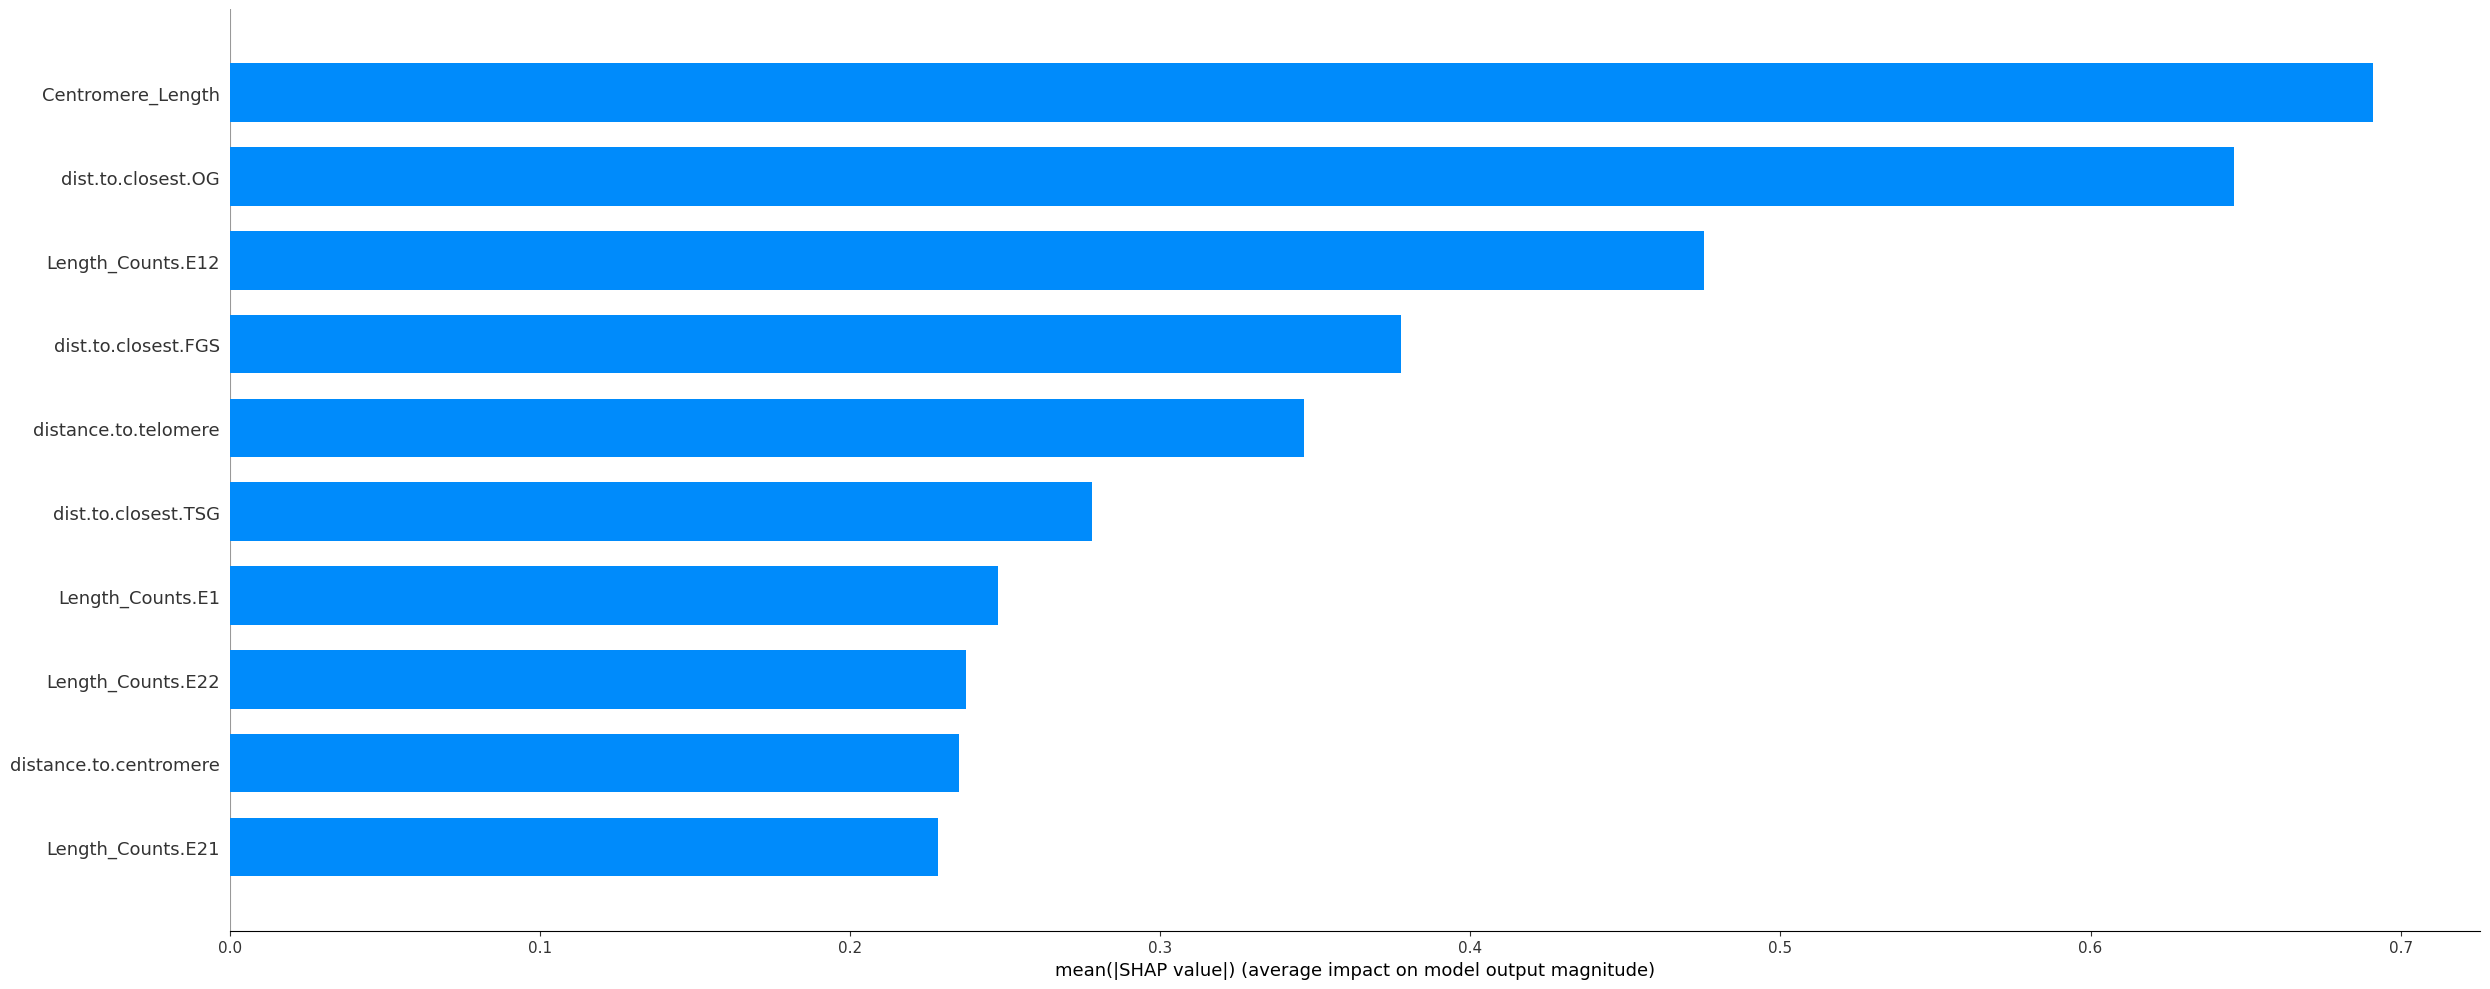

In [27]:
if plot_shap:
    print(" / ".join([mode, condition]))
    plt.figure(figsize = (100,25))
    summary_plot = shap.summary_plot(shap_values, X_train, 
                                     plot_type='bar', max_display=10, plot_size= (25,10))
    plt.show()

## Feature Selection

Let's perform Feature Selection using mean absolute SHAP values

> threshold=0.0, features=49, gini coefficient=0.6410420658415078
> threshold=0.0, features=49, gini coefficient=0.6410420658415078
> threshold=0.014751424081623554, features=47, gini coefficient=0.6476455840699201
> threshold=0.027560792863368988, features=46, gini coefficient=0.642134844392057
> threshold=0.03156188502907753, features=45, gini coefficient=0.6436933908905607
> threshold=0.03457184508442879, features=44, gini coefficient=0.6448791068453233
> threshold=0.04214482009410858, features=43, gini coefficient=0.6543900182546853
> threshold=0.04290907829999924, features=42, gini coefficient=0.6413431719176897
> threshold=0.04697283357381821, features=41, gini coefficient=0.6384945219416295
> threshold=0.04776138439774513, features=40, gini coefficient=0.6528196565966261
> threshold=0.04870938882231712, features=39, gini coefficient=0.6452966123203804
> threshold=0.05575280264019966, features=38, gini coefficient=0.6523440731024567
> threshold=0.0588080994784832, features=37, gi

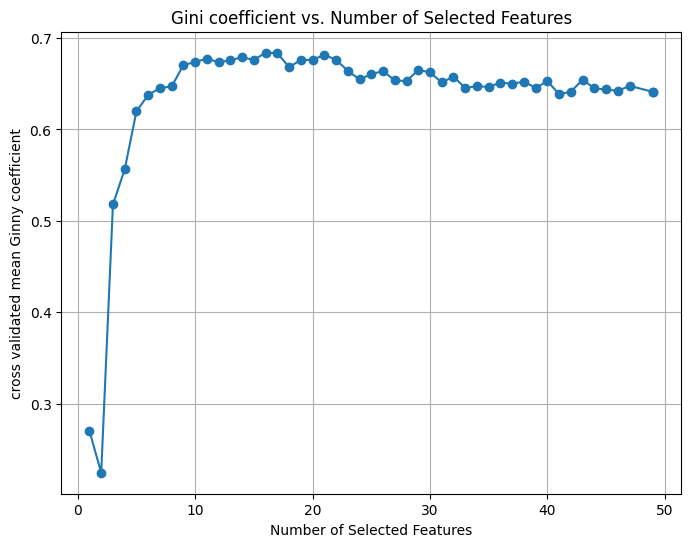

Optimal Threshold: 0.1325
Number of Selected Features: 16
Gini coef at Optimal Threshold: 0.6839


Selected features are: 

mean.GC.content  dist.to.closest.FGS  Length_Counts.E1  Length_Counts.E12  Length_Counts.E13
Length_Counts.E2  Length_Counts.E21  Length_Counts.E22  Length_Counts.E25  dist.to.closest.OG
dist.to.closest.TSG  distance.to.centromere  distance.to.telomere  HAPLOscore_pancancer  Chromosome_Length
Centromere_Length


Discarded features are: 

total_n_partners.trans  total_n_PPIs.trans_IntINSIDER  total_n_ohnologs.mmpaper_trans  total_n_paralogs_trans  Length_Counts.E10
Length_Counts.E11  Length_Counts.E14  Length_Counts.E15  Length_Counts.E16  Length_Counts.E17
Length_Counts.E18  Length_Counts.E19  Length_Counts.E20  Length_Counts.E23  Length_Counts.E24
Length_Counts.E3  Length_Counts.E4  Length_Counts.E5  Length_Counts.E6  Length_Counts.E7
Length_Counts.E8  Length_Counts.E9  all.int.trans_IntINSIDER  genes.bin  partners.trans
density.OG  density.TSG  mutations_norm  E

In [28]:
feature_names = model.feature_names_in_
feature_importances_shap = np.mean(np.abs(explainer.shap_values(X_train)), axis = 0)

X_train_reduced, X_test_reduced, selected_features = feature_selector_shap(feature_names, feature_importances_shap, 
                                                                            model, X_train, X_test, y_train, 
                                                                            inner_cv = inner_cv,
                                                                            plot = True, verbose = True)

In [29]:
features_to_discard = [feature for feature in selected_features if feature not in selected_features_in_at_least_one_cv]

In [30]:
print(f"Dropping columns never selected during Nested Cross Validation: {features_to_discard}")

Dropping columns never selected during Nested Cross Validation: []


In [31]:
X_train_reduced = X_train_reduced.drop(features_to_discard, axis = 1)
X_test_reduced = X_test_reduced.drop(features_to_discard, axis = 1)

In [32]:
opti_fs = sk.model_selection.RandomizedSearchCV(estimator = model, 
                                                param_distributions = search_space_grid, 
                                                cv = inner_cv, 
                                                n_jobs = n_jobs,
                                                n_iter = n_iter_rsearch,
                                                random_state = hypertune_random_state_rsearch, 
                                                verbose = 0, refit = True)
opti_fs.fit(X_train_reduced, y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster='dart',
                                           callbacks=None,
                                           colsample_bylevel=0.8040152711120385,
                                           colsample_bynode=None,
                                           colsample_bytree=0.9718661543412053,
                                           device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='error',
                                           feature_types=None,
                                           feature_weights=None,
                                           gamma=0.15745164171614615,
                                           grow_policy...
                                                      1.5741539770115064e-06],
                                        'reg_lambda': [0.25214674245184693,
                                                       0.9611580757120047,
                                                       2.619093381364049, 10.0,
                                                       1.3002135320318957e-08],
                                        'scale_pos_weight': [1.642825824640402,
                                                             2.3444329013314236,
                                                             1.4257870874904865,
                                                             1.4493937665642953,
                                                             1.2899420512630508],
                                        'subsample': [0.7717456158038967,
                                                      0.9852373968349232,
                                                      0.7774917033919722,
                                                      0.8198995084011427,
                                                      0.9831149178054596]},
                   random_state=49574)

In [33]:
model_fs = opti_fs.best_estimator_

In [34]:
best_params_fs = opti_fs.best_params_

In [35]:
for k,v in best_params_fs.items():
    print(f"{k}: {v}")

subsample: 0.9831149178054596
scale_pos_weight: 1.4493937665642953
reg_lambda: 10.0
reg_alpha: 0.6186554357168547
objective: binary:logistic
n_estimators: 133
min_child_weight: 3
max_depth: 15
max_delta_step: 2
learning_rate: 0.11400742746792061
gamma: 3.781144483207027e-09
eval_metric: logloss
colsample_bytree: 0.9718661543412053
colsample_bylevel: 0.8396691354598732
booster: gbtree


## Optimize Classification threshold

In [36]:
tuner_thr = sk.model_selection.TunedThresholdClassifierCV(model_fs, 
                                                          scoring = "balanced_accuracy", 
                                                          cv = inner_cv)
model_thr = tuner_thr.fit(X_train_reduced, y_train)

In [37]:
best_thr = model_thr.best_threshold_

In [38]:
print(f"Tuned Classification Threshold is: {best_thr}")

Tuned Classification Threshold is: 0.48474064469337463


## Evaluate Model Performances

In [39]:
accuracy_array_thr = np.mean(sk.model_selection.cross_val_score(model_thr, X_train_reduced, y_train, cv = outer_cv, scoring = "accuracy"))
f1_array_thr = np.mean(sk.model_selection.cross_val_score(model_thr, X_train_reduced, y_train, cv = outer_cv, scoring = "f1"))
precision_array_thr = np.mean(sk.model_selection.cross_val_score(model_thr, X_train_reduced, y_train, cv = outer_cv, scoring = "precision"))
recall_array_thr = np.mean(sk.model_selection.cross_val_score(model_thr, X_train_reduced, y_train, cv = outer_cv, scoring = "recall"))
roc_auc_array_thr = np.mean(sk.model_selection.cross_val_score(model_thr, X_train_reduced, y_train, cv = outer_cv, scoring = "roc_auc"))
proba_predictions_thr = sk.model_selection.cross_val_predict(model_thr, X_train_reduced, y_train, cv = outer_cv, method= "predict_proba")[:,1]
class_array_thr = sk.model_selection.cross_val_predict(model_thr, X_train_reduced, y_train, cv = outer_cv, method= "predict")

In [40]:
print(f"The cross-validated accuracy (cv = {outer_cv}) is: {np.mean(accuracy_array_thr)}")
print(f"The cross-validated f1 score(cv = {outer_cv}) is: {np.mean(f1_array_thr)}")
print(f"The cross-validated precision (cv = {outer_cv}) is: {np.mean(precision_array_thr)}")
print(f"The cross-validated recall(cv = {outer_cv}) is: {np.mean(recall_array_thr)}")
print(f"The cross-validated roc auc (cv = {outer_cv}) is: {np.mean(roc_auc_array_thr)}")

The cross-validated accuracy (cv = 5) is: 0.7794231513743709
The cross-validated f1 score(cv = 5) is: 0.7678152560604122
The cross-validated precision (cv = 5) is: 0.7965129564123178
The cross-validated recall(cv = 5) is: 0.747274569402229
The cross-validated roc auc (cv = 5) is: 0.8620433136127972


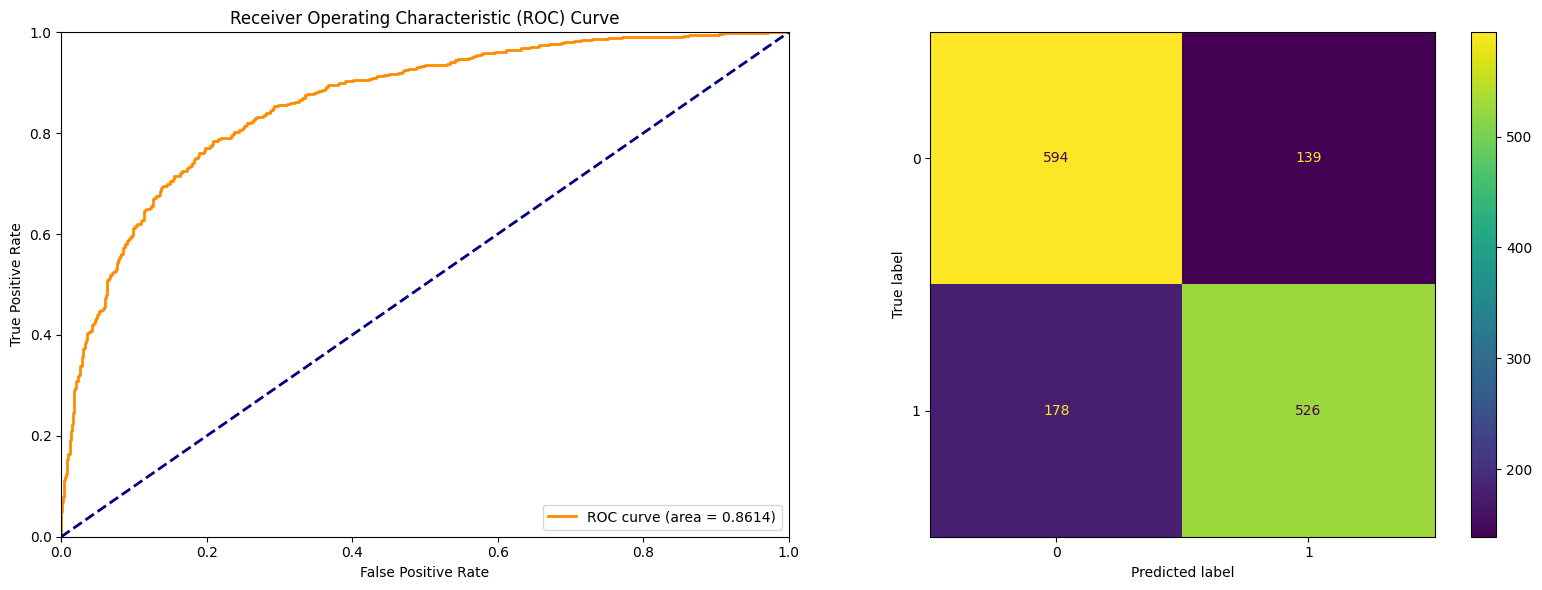

In [41]:
fpr, tpr, thresholds = sk.metrics.roc_curve(y_train, proba_predictions_thr)
roc_auc = sk.metrics.auc(fpr, tpr)

cm = sk.metrics.confusion_matrix(y_train, class_array_thr)
disp = sk.metrics.ConfusionMatrixDisplay(confusion_matrix=cm)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {np.mean(roc_auc):.4f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.0])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[0].legend(loc='lower right')

disp.plot(ax=axes[1])
plt.tight_layout()
plt.show()

## Store Variables for later

In [42]:
pickle.dump(X_train_reduced,open(X_train_filename,"wb"))
pickle.dump(X_test_reduced,open(X_test_filename,"wb"))
pickle.dump(y_train,open(y_train_filename,"wb"))
pickle.dump(y_test,open(y_test_filename,"wb"))
pickle.dump(bin_train,open(bin_train_filename,"wb"))
pickle.dump(bin_test,open(bin_test_filename,"wb"))
pickle.dump(model_thr,open(model_filename,"wb"))